In [1]:
import sys
sys.path.append('..')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geohash2 import decode_exactly
from src.data.prepare import prepare_data
from src.features.create_features import create_features
from src.models.loss import calc_rmse

pd.options.mode.chained_assignment = None

from src.models.model import Model
from src.data.dataset import create_dataset

In [2]:
tf.keras.backend.clear_session()

In [3]:
np.random.seed(42)

# 1. Data

In [36]:
df = pd.read_csv("../data/training.csv")

In [5]:
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [37]:
df = prepare_data(df, impute=True)

In [7]:
df.head()

,geohash6,lat,long,day,hour,minute,demand
0,qp03wc,-5.353088,90.653687,1,0,0,0.054858
1,qp03wc,-5.353088,90.653687,1,0,15,0.086209
2,qp03wc,-5.353088,90.653687,1,0,30,0.050739
3,qp03wc,-5.353088,90.653687,1,0,45,0.075174
4,qp03wc,-5.353088,90.653687,1,1,0,0.062867


# 2. Features Engineering

In [38]:
df = create_features(df)

I am adding 2 additional features, which are recurring day (eg. day 15 is basically day 1 just 2 weeks apart) and time binnings (morning, afternoon, evening, night)

In [9]:
df.head()

,geohash6,lat,long,day,hour,minute,demand,recur_day,time_bin,recur_day_1,recur_day_2,recur_day_3,recur_day_4,recur_day_5,recur_day_6,recur_day_7,time_bin_morning,time_bin_afternoon,time_bin_evening,time_bin_night
0,qp03wc,-5.353088,90.653687,1,0,0,0.054858,1,night,1,0,0,0,0,0,0,0,0,0,1
1,qp03wc,-5.353088,90.653687,1,0,15,0.086209,1,night,1,0,0,0,0,0,0,0,0,0,1
2,qp03wc,-5.353088,90.653687,1,0,30,0.050739,1,night,1,0,0,0,0,0,0,0,0,0,1
3,qp03wc,-5.353088,90.653687,1,0,45,0.075174,1,night,1,0,0,0,0,0,0,0,0,0,1
4,qp03wc,-5.353088,90.653687,1,1,0,0.062867,1,night,1,0,0,0,0,0,0,0,0,0,1


# 3. Baseline

In [10]:
baseline_train = df[df.day < 61]
baseline_val = df[df.day == 61]

In [11]:
baseline_model = baseline_train.groupby(["geohash6", "recur_day", "hour", "minute"]).demand.median()

The baseline basically use previous median values to forecast the future.

In [12]:
baseline_actual = np.array(baseline_val.demand.to_list())

baseline_pred = np.array(baseline_model.loc[
    [tuple(x) for x in baseline_val[["geohash6", "recur_day", "hour", "minute"]].values]
].reset_index().demand.to_list())

In [13]:
calc_rmse(baseline_actual, baseline_pred)

0.04544460790419308

# 4. Model

In [7]:
model = Model()

I am using walk forward sliding window to generate train dataset to predict the next timestamp with look back to 14 days and no validation. The training is only for 1 epoch for all window combination.

In [24]:
dataset = create_dataset(df, epochs=1)

The model I am using is basically seq2one (encoder-decoder) with attention where both encoder and decoder each has 1 GRU layer. 

In [16]:
model.train(dataset)

Iter 1 Loss 0.00021813801140524447 Time 7.244473695755005
Iter 101 Loss 0.0001705877366475761 Time 0.011981725692749023
Iter 201 Loss 0.00015601638006046414 Time 0.010291576385498047
Iter 301 Loss 6.945043423911557e-05 Time 0.01093912124633789
Iter 401 Loss 0.0003962534829042852 Time 0.01298832893371582
Iter 501 Loss 0.00020281996694393456 Time 0.011970043182373047
Iter 601 Loss 4.742551391245797e-05 Time 0.013673782348632812
Iter 701 Loss 0.00014970218762755394 Time 0.011967897415161133
Iter 801 Loss 0.0001676604151725769 Time 0.01299285888671875
Iter 901 Loss 1.4227234714780934e-05 Time 0.011936426162719727
Iter 1001 Loss 6.843081791885197e-05 Time 0.012966156005859375
Iter 1101 Loss 9.726829739520326e-05 Time 0.014020919799804688
Iter 1201 Loss 1.8497452401788905e-05 Time 0.01294255256652832
Iter 1301 Loss 1.1772755897254683e-05 Time 0.013962984085083008
Iter 1401 Loss 4.722217272501439e-05 Time 0.01594090461730957
Iter 1501 Loss 6.019297143211588e-05 Time 0.013530969619750977
Iter 

KeyboardInterrupt: 

Let's see how the model fit the training set.

In [8]:
model.checkpoint.restore(tf.train.latest_checkpoint(model.checkpoint_dir))

In [50]:
fit_df = df[df.geohash6 == "qp09sw"]
feature_columns = fit_df.columns.drop(["geohash6", "recur_day", "time_bin"])
fit_data = np.expand_dims(np.array(fit_df[feature_columns]), axis=0)

In [51]:
actual = fit_data[0, :, 5]

In [52]:
pred = []
for t in range(1, 500):
    out, _ = model(np.expand_dims(fit_data[0, :t], axis=0))
    pred.append(np.squeeze(out))

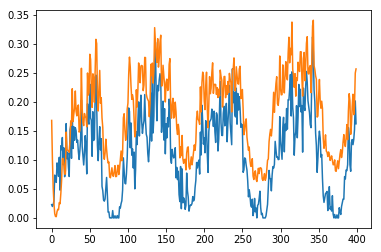

In [53]:
fig, ax = plt.subplots()

ax.plot(range(0, 400), fit_data[0,:400,5])
ax.plot(range(0, 400), pred[:400])